# Higgs Twitter Dataset — Reusable Analysis Notebook

This notebook provides a **clean, repeatable workflow** for exploring the **Higgs Twitter dataset** (SNAP).
It is written to be **portable**: you can reuse the same structure for other datasets by only changing the *Data Loading* and *Preprocessing* sections.

**Dataset page (SNAP):** https://snap.stanford.edu/data/higgs-twitter.html

## What’s in this dataset?

The Higgs Twitter dataset is typically distributed as **five files**:

1. **Follower graph** (directed): who follows whom (`higgs-social_network.edgelist`)
2. **Retweet network**: aggregated retweet edges (`higgs-retweet_network.edgelist`)
3. **Reply network**: aggregated reply edges (`higgs-reply_network.edgelist`)
4. **Mention network**: aggregated mention edges (`higgs-mention_network.edgelist`)
5. **Activity log (temporal)**: event-level interactions (`higgs-activity_time.txt`)

## Objectives
- Validate files exist and load correctly
- Inspect schemas and sample rows
- Compute lightweight descriptive stats (streaming-friendly)
- Prepare a clean temporal event table for downstream analysis (bursts, cascades, diffusion)
"""),


## 1. Environment Setup
All imports and global settings live here to avoid repetition later.


In [31]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)


## 2. Dataset Paths


In [3]:
# Walk upwards until we find a folder that contains "src/"
p = Path.cwd().resolve()
while p != p.parent and not (p / "src").exists():
    p = p.parent

if not (p / "src").exists():
    raise RuntimeError("Could not find project root (folder containing 'src').")

sys.path.insert(0, str(p))

print("Project root:", p)
print("Has src?:", (p / "src").exists())



Project root: /mnt/c/Users/rescic/PycharmProjects/dezinfo-datasets
Has src?: True


In [4]:
from pathlib import Path
import pandas as pd

from src.core.config import SETTINGS


DATASET_DIR = Path(SETTINGS.DATA_ROOT) / "higgs-twitter"
DATASET_DIR

PosixPath('/home/rescic/dezinfo_data/higgs-twitter')

In [5]:
FILES = {
    "social_network": "higgs-social_network.edgelist",
    "retweet_network": "higgs-retweet_network.edgelist",
    "reply_network": "higgs-reply_network.edgelist",
    "mention_network": "higgs-mention_network.edgelist",
    "activity_time": "higgs-activity_time.txt",
}

paths = {k: DATASET_DIR / v for k, v in FILES.items()}
missing = [k for k, fn in FILES.items() if not (DATASET_DIR / fn).exists()]
missing



[]

## 3. Data Loading Helpers

### Why helpers?
In large SNAP datasets, files can be big. These helpers make it easy to:
- read **sample rows** quickly
- compute **streaming statistics** without loading full files into memory
- keep code consistent across multiple datasets (reduces redundancy)

In [35]:
def read_head_whitespace(path: Path, nrows: int = 5) -> pd.DataFrame:
    return pd.read_csv(path, sep=r"\s+", header=None, nrows=nrows, engine="python")


def label_edgelist(df: pd.DataFrame) -> pd.DataFrame:
    # keep only first 2 columns (src, dst); ignore weights if present
    df = df.iloc[:, :2].copy()
    df.columns = ["src", "dst"]
    return df

def label_activity(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = ["userA", "userB", "timestamp", "interaction"]
    return df

def sample_edges(path: Path, n: int = 200_000, seed: int = 7) -> pd.DataFrame:
    df = pd.read_csv(
        path,
        sep=r"\s+",          # ✅ correct
        header=None,
        nrows=n,
        engine="python",
        comment="#",
        on_bad_lines="skip",
        usecols=[0, 1],      # ✅ enforce src,dst
    )
    df = label_edgelist(df)
    return df.sample(frac=1.0, random_state=seed).reset_index(drop=True)


## 4. Schema Inspection


This step is a **sanity check**:
- confirm each file is readable
- confirm column structure matches expectations
- spot obvious issues early (e.g., empty files, wrong delimiter, truncated downloads)

In [7]:
for key in ["social_network", "retweet_network", "reply_network", "mention_network"]:
    df = label_edgelist(read_head_whitespace(paths[key]))
    print(key)
    display(df)

activity_head = label_activity(read_head_whitespace(paths["activity_time"]))
display(activity_head)


social_network


,src,dst
0,1,2
1,1,3
2,1,4
3,1,5
4,1,6


retweet_network


,src,dst,weight
0,298960,105232,1
1,95688,3393,1
2,353237,62217,1
3,4974,3571,1
4,241892,8,1


reply_network


,src,dst,weight
0,161345,8614,1
1,428368,11792,1
2,77904,10701,1
3,124554,286277,1
4,194873,194873,1


mention_network


,src,dst,weight
0,316609,5011,1
1,439696,12389,1
2,60059,6929,1
3,161345,8614,1
4,137487,759,1


,userA,userB,timestamp,interaction
0,223789,213163,1341100972,MT
1,223789,213163,1341100972,RE
2,376989,50329,1341101181,RT
3,26375,168366,1341101183,MT
4,376989,13813,1341101192,RT


## 5. Lightweight Descriptive Statistics (Streaming-Friendly)

Many Higgs Twitter files are large. Instead of loading everything into RAM,
we compute basic stats by **streaming** through the file in chunks.

Computed metrics for edge lists:
- number of edges
- number of unique nodes (approx. exact via streaming set; may be memory-heavy for huge graphs)
- self-loops
- degree summaries (max in/out)

> Note: For extremely large graphs, storing all unique nodes in a set can still be heavy.
> If that becomes an issue, we can switch to approximate distinct counts (e.g., HyperLogLog).

In [15]:
from collections import Counter

def stream_edgelist_stats(path: Path, chunksize: int = 2_000_000):
    nodes = set()
    edges = 0
    self_loops = 0
    out_deg = Counter()
    in_deg = Counter()

    reader = pd.read_csv(
        path,
        sep=r"\s+",
        header=None,
        usecols=[0, 1],          # force exactly two columns
        chunksize=chunksize,
        engine="python",
        on_bad_lines="skip",     # skip malformed rows
        comment="#",             # ignore comment lines if present
    )

    for chunk in reader:
        # Drop rows where either endpoint is missing
        chunk = chunk.dropna()
        if chunk.shape[1] < 2 or chunk.empty:
            continue

        src = pd.to_numeric(chunk.iloc[:, 0], errors="coerce")
        dst = pd.to_numeric(chunk.iloc[:, 1], errors="coerce")

        # Drop rows that failed numeric conversion
        mask = src.notna() & dst.notna()
        src = src[mask].astype("int64")
        dst = dst[mask].astype("int64")

        edges += len(src)
        self_loops += int((src == dst).sum())

        out_deg.update(src.tolist())
        in_deg.update(dst.tolist())

        nodes.update(src.tolist())
        nodes.update(dst.tolist())

    n_nodes = len(nodes)
    return {
        "edges": int(edges),
        "nodes": int(n_nodes),
        "self_loops": int(self_loops),
        "avg_out_degree": float(edges / n_nodes) if n_nodes else float("nan"),
        "avg_in_degree": float(edges / n_nodes) if n_nodes else float("nan"),
        "max_out_degree": int(max(out_deg.values())) if out_deg else 0,
        "max_in_degree": int(max(in_deg.values())) if in_deg else 0,
    }

stats = {}
for key in ["social_network", "retweet_network", "reply_network", "mention_network"]:
    stats[key] = stream_edgelist_stats(paths[key])

pd.DataFrame(stats).T



,edges,nodes,self_loops,avg_out_degree,avg_in_degree,max_out_degree,max_in_degree
social_network,14855842.0,456626.0,23.0,32.533938,32.533938,1259.0,51386.0
retweet_network,328132.0,256491.0,0.0,1.279312,1.279312,134.0,14060.0
reply_network,32523.0,38918.0,343.0,0.835680,0.835680,35.0,1206.0
mention_network,150818.0,116408.0,5353.0,1.295598,1.295598,169.0,11953.0


## 6. Temporal Event Table (Preprocessing)

The activity log enables time-based analysis (bursts, cascades, diffusion).

### Preprocessing goals
- Convert Unix timestamps → `datetime`
- Standardize interaction codes: `RT`, `RE`, `MT`
- Create helpful derived fields:
  - `date`, `hour`
  - optional: `day_index` relative to dataset start

In [23]:
def read_activity(path: Path, chunksize: int | None = None) -> pd.DataFrame:
    df = pd.read_csv(
        path,
        sep=r"\s+",
        header=None,
        engine="python",
        comment="#",
        on_bad_lines="skip",
        usecols=[0, 1, 2, 3],   # enforce 4 columns
        chunksize=chunksize,
    )
    return df

activity = read_activity(paths["activity_time"])
activity.columns = ["userA", "userB", "timestamp", "interaction"]
activity.head()


,userA,userB,timestamp,interaction
0,223789,213163,1341100972,MT
1,223789,213163,1341100972,RE
2,376989,50329,1341101181,RT
3,26375,168366,1341101183,MT
4,376989,13813,1341101192,RT


In [24]:
activity["timestamp"] = pd.to_numeric(activity["timestamp"], errors="coerce")
activity = activity.dropna(subset=["timestamp"])

activity["datetime"] = pd.to_datetime(activity["timestamp"].astype("int64"), unit="s", utc=True)
activity["date"] = activity["datetime"].dt.date
activity["hour"] = activity["datetime"].dt.floor("1h")

activity["interaction"].value_counts(dropna=False)


interaction
RT    354930
MT    171237
RE     36902
Name: count, dtype: int64

### Event volume over time

This plot is a quick check for spikes and seasonality-like patterns.
You can repeat this pattern for other datasets: define a time bucket and count events.

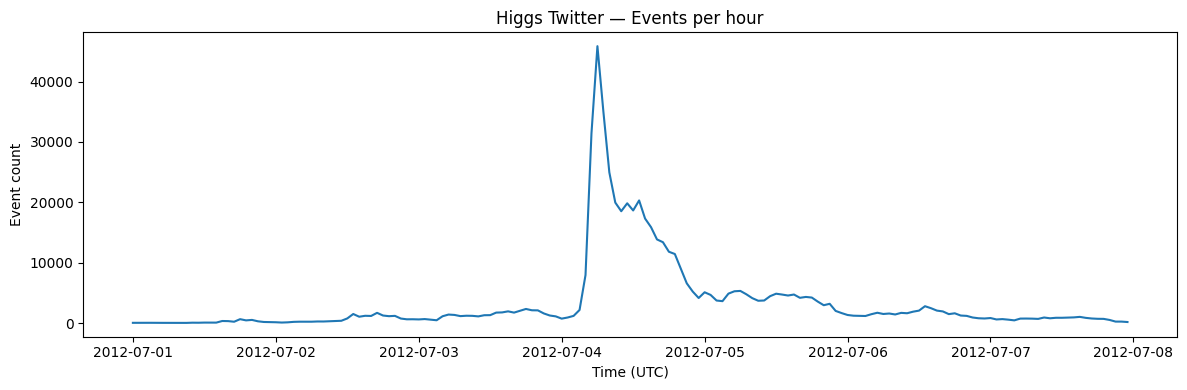

In [25]:
events_per_hour = activity.groupby("hour").size()

plt.figure(figsize=(12, 4))
plt.plot(events_per_hour.index, events_per_hour.values)
plt.title("Higgs Twitter — Events per hour")
plt.xlabel("Time (UTC)")
plt.ylabel("Event count")
plt.tight_layout()
plt.show()

# 7. Focused Analysis

- **Burst detection**: identify key spikes and correlate with known dates (announcement / news cycles)
- **Interaction mix over time**: RT vs RE vs MT proportions by day/hour
- **Cascade analysis**: measure retweet cascades if tweet-level info is available (not always in this release)
- **Graph sampling**: build subgraphs for SCCs, centrality, or community detection

Below are two reusable mini-analyses: interaction mix over time and a small SCC example on a sampled graph.

### 7.1 Interaction mix over time (by day)


In [26]:
mix_by_day = activity.pivot_table(
    index="date", columns="interaction", values="timestamp", aggfunc="count", fill_value=0
)

mix_by_day.head()



interaction,MT,RE,RT
date,,,
2012-07-01,1749,285,2136
2012-07-02,5600,1226,9248
2012-07-03,11860,2216,19426
2012-07-04,101279,21778,233331
2012-07-05,29329,7021,62292


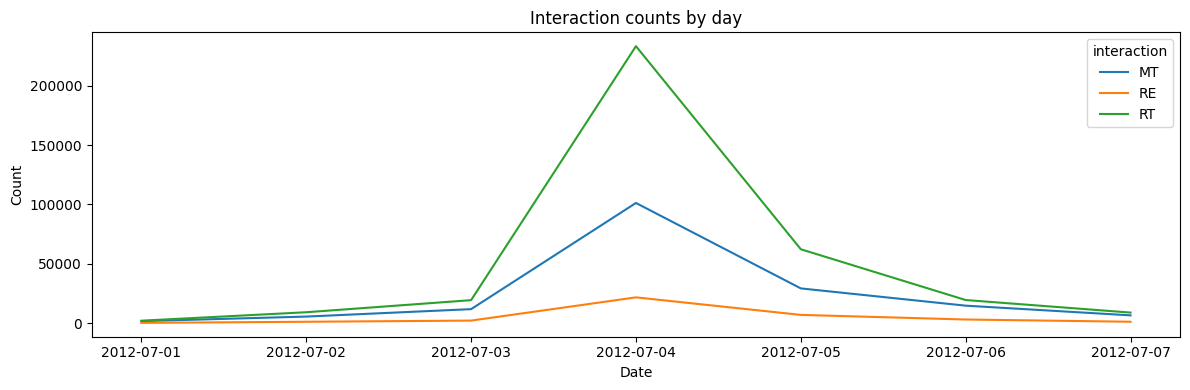

In [27]:
mix_by_day.plot(figsize=(12, 4))
plt.title("Interaction counts by day")
plt.xlabel("Date")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### 7.2 SCCs on a sampled edge list

1. sample edges (or nodes)
2. build a smaller graph
3. compute SCCs for qualitative insight

In [36]:
# Optional dependency: networkx
import networkx as nx

sample = sample_edges(paths["social_network"], n=200_000, seed=7)
G = nx.from_pandas_edgelist(sample, source="src", target="dst", create_using=nx.DiGraph)

sccs = list(nx.strongly_connected_components(G))
sizes = sorted((len(c) for c in sccs), reverse=True)

{
    "sample_edges": G.number_of_edges(),
    "sample_nodes": G.number_of_nodes(),
    "num_sccs": len(sccs),
    "largest_scc_size": sizes[0] if sizes else 0,
    "top10_scc_sizes": sizes[:10],
}

{'sample_edges': 200000,
 'sample_nodes': 52600,
 'num_sccs': 50580,
 'largest_scc_size': 1997,
 'top10_scc_sizes': [1997, 3, 3, 2, 2, 2, 2, 2, 2, 2]}

## 7. Interaction Mix by Day


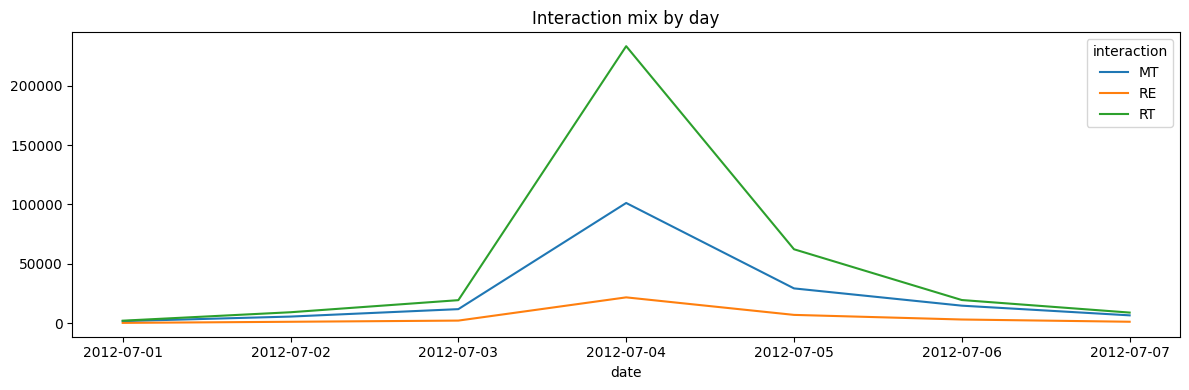

In [10]:
mix = activity.pivot_table(index="date", columns="interaction", values="timestamp", aggfunc="count", fill_value=0)
mix.plot(figsize=(12,4))
plt.title("Interaction mix by day")
plt.tight_layout()
plt.show()
